### Notebook Overview

1. **Preprocessing Images**:
   - The images in the dataset come in different sizes. We will preprocess them by cropping to dimensions divisible by 256 to ensure uniformity.

2. **Handling Mask Colors**:
   - The mask images contain HEXA codes that need to be converted to RGB format for proper representation.

3. **One-Hot Encoding**:
   - Since this is a multi-class segmentation problem, we will convert the RGB values into one-hot encoded format for model training.

4. **Reconversion of Predicted Images**:
   - After prediction, the images will need to be converted back to their original RGB colors.

We will use the **patchify** library for image cropping and extracting patches. The patch size will be (256, 256), meaning we need to divide the original images into tiles of (n_rows, n_cols) that are divisible by 256.

The **U-Net architecture** will be implemented for this segmentation problem using TensorFlow's Keras API.

In [1]:
# Importing required libraries
!pip install patchify

# Standard libraries
from pathlib import Path
from patchify import patchify
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# TensorFlow and Keras libraries
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import (
    Input, 
    Conv2D, 
    BatchNormalization, 
    ReLU, 
    SpatialDropout2D, 
    MaxPooling2D, 
    Conv2DTranspose, 
    concatenate
)

# Metrics and Loss functions
from tensorflow.keras.metrics import OneHotIoU, Recall, Precision
from tensorflow.keras.losses import CategoricalFocalCrossentropy, Dice
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Define the directory containing the dataset
directory = Path('/kaggle/input/semantic-segmentation-of-aerial-imagery')
scaler = MinMaxScaler()
patch_size = 256
image_dataset = []

# Walk through the directory to find images
for path in directory.glob('**/images'):
    images = sorted(path.glob('*.jpg'))  
    print(f'Found images in: {path.name}')
    print([img.name for img in images])
    
    for image_path in images:
        image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
        
        if image is None:
            print(f'Error loading image: {image_path}')
            continue  # Skip if image is not loaded properly
        
        # Resize the image to be divisible by the patch size
        x_size = (image.shape[1] // patch_size) * patch_size
        y_size = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image).crop((0, 0, x_size, y_size))
        image = np.array(image)

        # Extract patches from each image with overlap
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

        # Normalize each patch and append to dataset
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                
                single_patch_img = single_patch_img[0]
                image_dataset.append(single_patch_img)


Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.j

In [3]:
# Define the patch size and initialize the mask dataset
patch_size = 256
mask_dataset = []

# Walk through the directory to find masks
for path in directory.glob('**/masks'):
    masks = sorted(path.glob('*.png'))  # List all png masks in sorted order
    print(f'Found masks in: {path.name}')
    print([mask.name for mask in masks])

    for mask_path in masks:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_COLOR)

        if mask is None:
            print(f'Error loading mask: {mask_path}')
            continue  # Skip if the mask is not loaded properly

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        x_size = (mask.shape[1] // patch_size) * patch_size
        y_size = (mask.shape[0] // patch_size) * patch_size
        mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))
        mask = np.array(mask)

        # Extract patches from each mask with overlap
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

        # Append each single patch to the mask dataset
        for row in range(patches_mask.shape[0]):
            for col in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[row, col, :, :]

                single_patch_mask = single_patch_mask[0]
                mask_dataset.append(single_patch_mask)


Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'imag

In [4]:
#converting the image and masks lists into arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Print shapes of the datasets
print(image_dataset.shape, mask_dataset.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


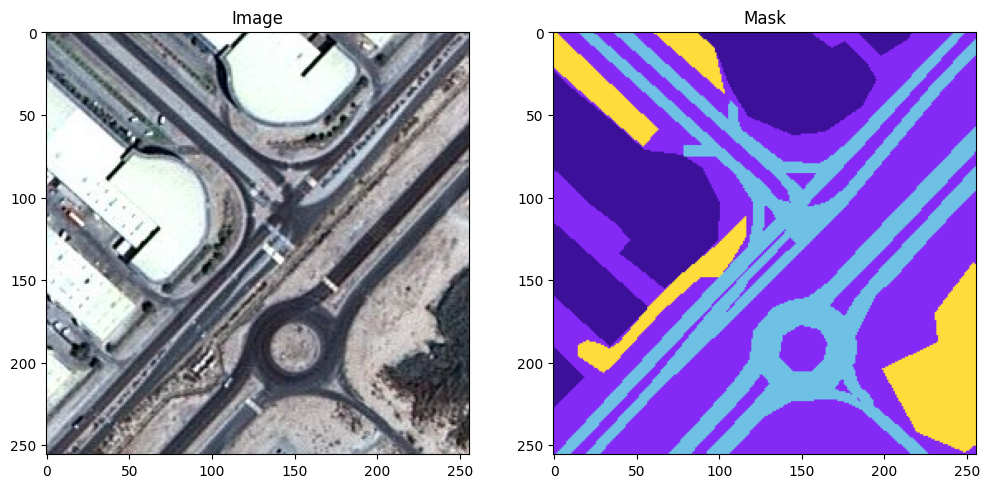

In [5]:
# Check the consistency between the images and masks 
check_number = np.random.randint(0, len(image_dataset))

# Create a figure to display the selected image and its corresponding mask
fig = plt.figure(figsize=(12, 10))
ax = fig.subplot_mosaic("""AB""")
ax['A'].imshow(image_dataset[check_number])
ax['A'].set_title('Image')
ax['B'].imshow(mask_dataset[check_number])
ax['B'].set_title('Mask')
plt.show()


In [6]:
# Define hexadecimal colors for each class
class_colors_hex = {
    'Building': '#3C1098',
    'Land': '#8429F6',
    'Road': '#6EC1E4',
    'Vegetation': '#FEDD3A',
    'Water': '#E2A929',
    'Unlabeled': '#9B9B9B'
}

# Function to convert hexadecimal colors to RGB integer values
def hex_to_int(hex_color):
    hex_color = hex_color.lstrip('#')  # Remove the '#' from the beginning
    return np.array(tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))  # Convert to RGB

# Create a dictionary mapping class names to their RGB integer values
class_colors = {key: hex_to_int(value) for key, value in class_colors_hex.items()}

# Print the RGB values for each class
print(class_colors)


{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [7]:
# Function to convert RGB colors in the label masks to integer labels
def rgb_to_2D_label(label):
    """
    Convert RGB mask to integer labels based on predefined class colors.

    Args:
        label (np.ndarray): Input mask in RGB format.

    Returns:
        np.ndarray: Segmentation mask with integer labels.
    """
    # Initialize a label mask with zeros
    label_seg = np.zeros(label.shape[:-1], dtype=np.uint8)
    
    # Assign integer labels based on RGB values
    for idx, color in enumerate(class_colors.values()):
        label_seg[np.all(label == color, axis=-1)] = idx  # Match the color

    return label_seg

# Convert all masks in mask_dataset to integer labels
labels = np.array([rgb_to_2D_label(mask) for mask in mask_dataset])  
labels = np.expand_dims(labels, axis=3)  # Add an extra dimension

# Display unique labels and the shape of the labels array
print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of the labels is: ", labels.shape)


Unique labels in label dataset are:  [0 1 2 3 4 5]
Shape of the labels is:  (1305, 256, 256, 1)


In [8]:
# Converting labels to categories using one-hot encoding
num_classes = len(class_colors)
labels_categ = to_categorical(labels, num_classes=num_classes)  

# Display the shape of the one-hot encoded labels
print("Shape of one-hot encoded labels:", labels_categ.shape)


Shape of one-hot encoded labels: (1305, 256, 256, 6)


In [9]:
# Splitting the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_categ, test_size=0.20, random_state=42)

# Further splitting the test data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Outputting the shapes of each split
print(f'Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape of validation data: X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'Shape of test data: X_test: {X_test.shape}, y_test: {y_test.shape}')

Shape of training data: X_train: (1044, 256, 256, 3), y_train: (1044, 256, 256, 6)
Shape of validation data: X_val: (130, 256, 256, 3), y_val: (130, 256, 256, 6)
Shape of test data: X_test: (131, 256, 256, 3), y_test: (131, 256, 256, 6)


In [10]:
# Data Augmentation
# Creating the data generators with specified augmentation parameters
batch_size = 32

data_gen_args = dict(
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


# Instantiate ImageDataGenerator for images and labels
image_data_gen = ImageDataGenerator(**data_gen_args)
label_data_gen = ImageDataGenerator(**data_gen_args)

def data_generator(image_data_gen, label_data_gen, X_train, y_train, batch_size):
    """
    Generator function that yields batches of augmented image and label data.

    Parameters:
    - image_data_gen: Augmentation configuration for images.
    - label_data_gen: Augmentation configuration for labels.
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of samples per batch.

    Yields:
    - Tuple of augmented image and label batches.
    """
    # Create generators for images and labels
    image_generator = image_data_gen.flow(X_train, batch_size=batch_size, seed=42)
    label_generator = label_data_gen.flow(y_train, batch_size=batch_size, seed=42)

    while True:
        # Get the next batch of images and labels
        X_batch = next(image_generator)
        y_batch = next(label_generator)

        yield X_batch, y_batch

# Initialize the training generator
train_generator = data_generator(image_data_gen, label_data_gen, X_train, y_train, batch_size)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, LayerNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention

# Swin Transformer block
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.mlp = tf.keras.Sequential([
            Dense(self.embed_dim, activation=tf.nn.gelu),
            Dense(self.embed_dim)
        ])
    
    def call(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x, x)
        x = shortcut + x
        x = self.norm2(x)
        x = self.mlp(x)
        return x

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Swin Transformer block
    swin_block = SwinTransformerBlock(num_heads=8, embed_dim=128)
    x = swin_block(p4)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Assuming metrics and loss are defined
metrics = ['accuracy']  # Replace 'jacard_coef' with the actual implementation if you have it
total_loss = 'categorical_crossentropy'  # Replace with the actual loss function if different

def get_model():
    return multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,551,430 (5.92 MB)

 Trainable params: 1,551,430 (5.92 MB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1044, 256, 256, 6) (6 channels).
  warnings.warn(


Epoch 1/20


I0000 00:00:1731686297.125691      87 service.cc:145] XLA service 0x7938f0002500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731686297.125760      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/32 ━━━━━━━━━━━━━━━━━━━━ 18:32 36s/step - dice_score: 0.2310 - jaccard_coeff: 0.1391 - loss: 1.4388 - one_hot_io_u_1: 0.1054 - precision_1: 0.4840 - recall_1: 0.0617 - segmentation_accuracy: 0.8265

I0000 00:00:1731686324.497203      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - dice_score: 0.4203 - jaccard_coeff: 0.3326 - loss: 1.1314 - one_hot_io_u_1: 0.1026 - precision_1: 0.7117 - recall_1: 0.3945 - segmentation_accuracy: 0.8671 - val_dice_score: 0.4331 - val_jaccard_coeff: 0.2840 - val_loss: 0.9875 - val_one_hot_io_u_1: 0.2297 - val_precision_1: 0.9041 - val_recall_1: 0.4292 - val_segmentation_accuracy: 0.9082
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - dice_score: 0.5058 - jaccard_coeff: 0.4253 - loss: 0.9319 - one_hot_io_u_1: 0.1980 - precision_1: 0.7852 - recall_1: 0.4806 - segmentation_accuracy: 0.8849 - val_dice_score: 0.5878 - val_jaccard_coeff: 0.4847 - val_loss: 0.8707 - val_one_hot_io_u_1: 0.2924 - val_precision_1: 0.7961 - val_recall_1: 0.5748 - val_segmentation_accuracy: 0.9143
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - dice_score: 0.5612 - jaccard_coeff: 0.4842 - loss: 0.8474 - one_hot_io_u_1: 0.2911 - precision_1: 0.8408 - recall_1: 0.5058 - segmentation_accuracy: 0.8975 - val_dice_scor

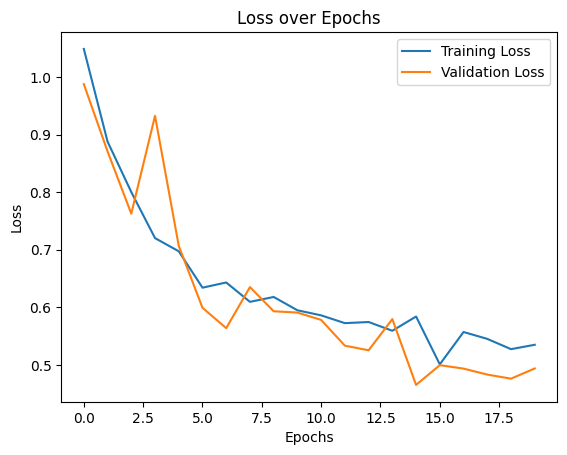

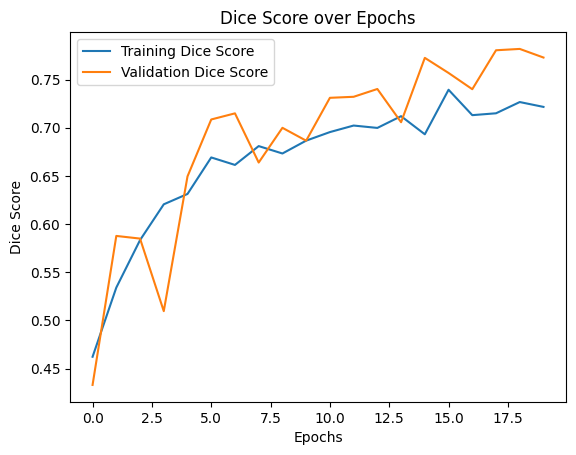

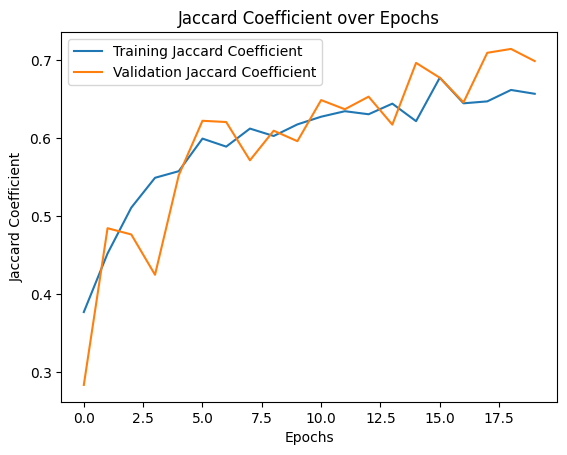

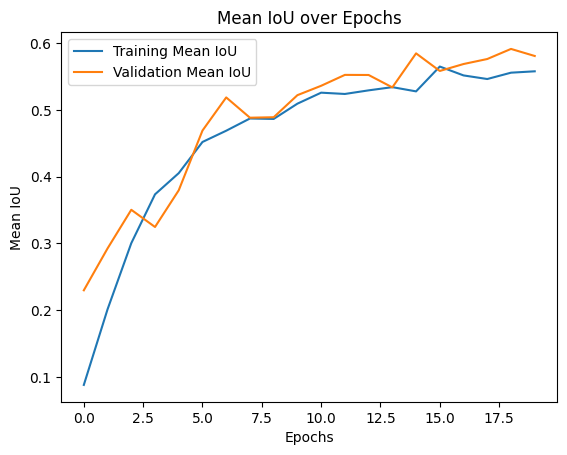

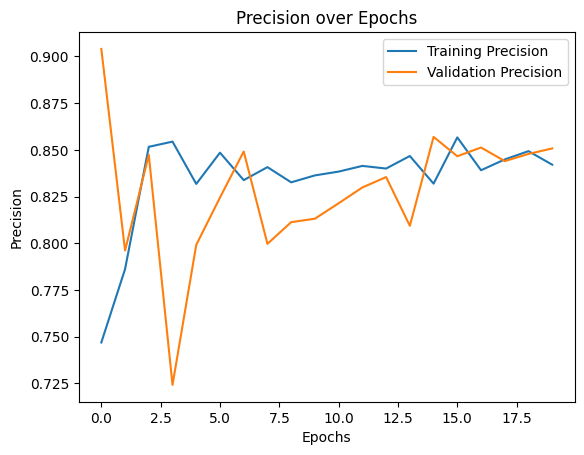

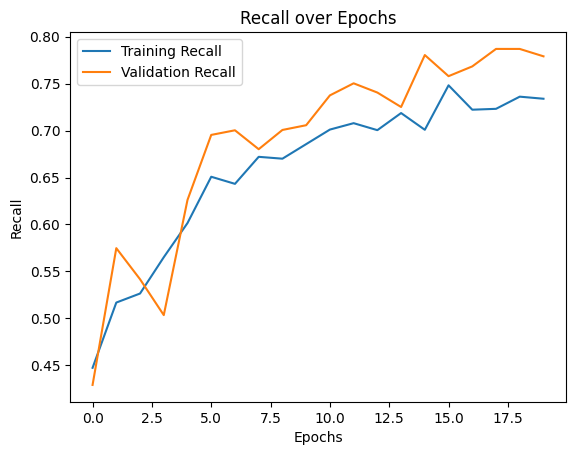

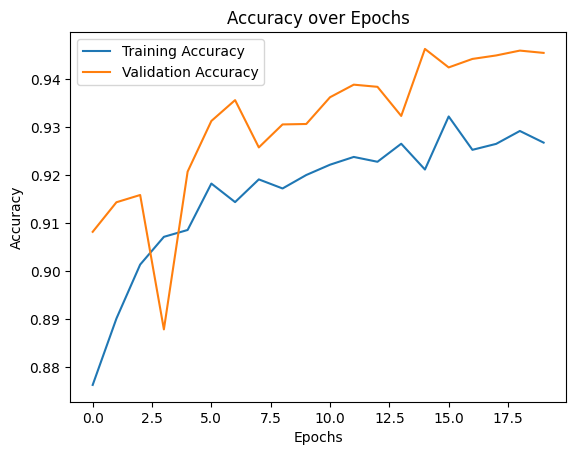

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Define metric functions
def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    union = tf.reduce_sum(y_true + y_pred, axis=(-1))
    jac = (intersection + smooth) / (union - intersection + smooth)
    return jac

# Metrics for model evaluation
# OneHotIoU measures the intersection over union for each class
metrics = [OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]), Precision(), Recall(), jaccard_coeff]

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(-1))
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return tf.reduce_mean(dice)

def segmentation_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# Define combined loss function (Dice + Focal)
focal = CategoricalFocalCrossentropy(alpha=0.5, gamma=1)
dice = Dice()

def combined_dice_focal_loss(y_true, y_pred):
    dice_loss = dice(y_true, y_pred)
    focal_loss = focal(y_true, y_pred)
    total_loss = focal_loss + dice_loss
    return total_loss

# Update metrics
metrics = [
    OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]),
    Precision(),
    Recall(),
    jaccard_coeff,
    dice_score,
    segmentation_accuracy
]

# Compile and train the model
model.compile(optimizer='adam', loss=combined_dice_focal_loss, metrics=metrics)
history = model.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=20, validation_data=(X_val, y_val))

# Check available keys in history
print(history.history.keys())

# Plotting function for all metrics
def plot_all_metrics(history):
    metrics_map = {
        'loss': 'Loss',
        'dice_score': 'Dice Score',
        'jaccard_coeff': 'Jaccard Coefficient',
        'one_hot_io_u_1': 'Mean IoU',
        'precision_1': 'Precision',
        'recall_1': 'Recall',
        'segmentation_accuracy': 'Accuracy'
    }

    for metric_key, label in metrics_map.items():
        try:
            plt.plot(history.history[metric_key], label=f'Training {label}')
            plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {label}')
            plt.xlabel('Epochs')
            plt.ylabel(label)
            plt.legend()
            plt.title(f'{label} over Epochs')
            plt.show()
        except KeyError:
            print(f"Metric '{metric_key}' not found in history. Please check the available keys.")

# Call the plotting function
plot_all_metrics(history)


In [13]:
print(history.history.keys())

dict_keys(['dice_score', 'jaccard_coeff', 'loss', 'one_hot_io_u_1', 'precision_1', 'recall_1', 'segmentation_accuracy', 'val_dice_score', 'val_jaccard_coeff', 'val_loss', 'val_one_hot_io_u_1', 'val_precision_1', 'val_recall_1', 'val_segmentation_accuracy'])


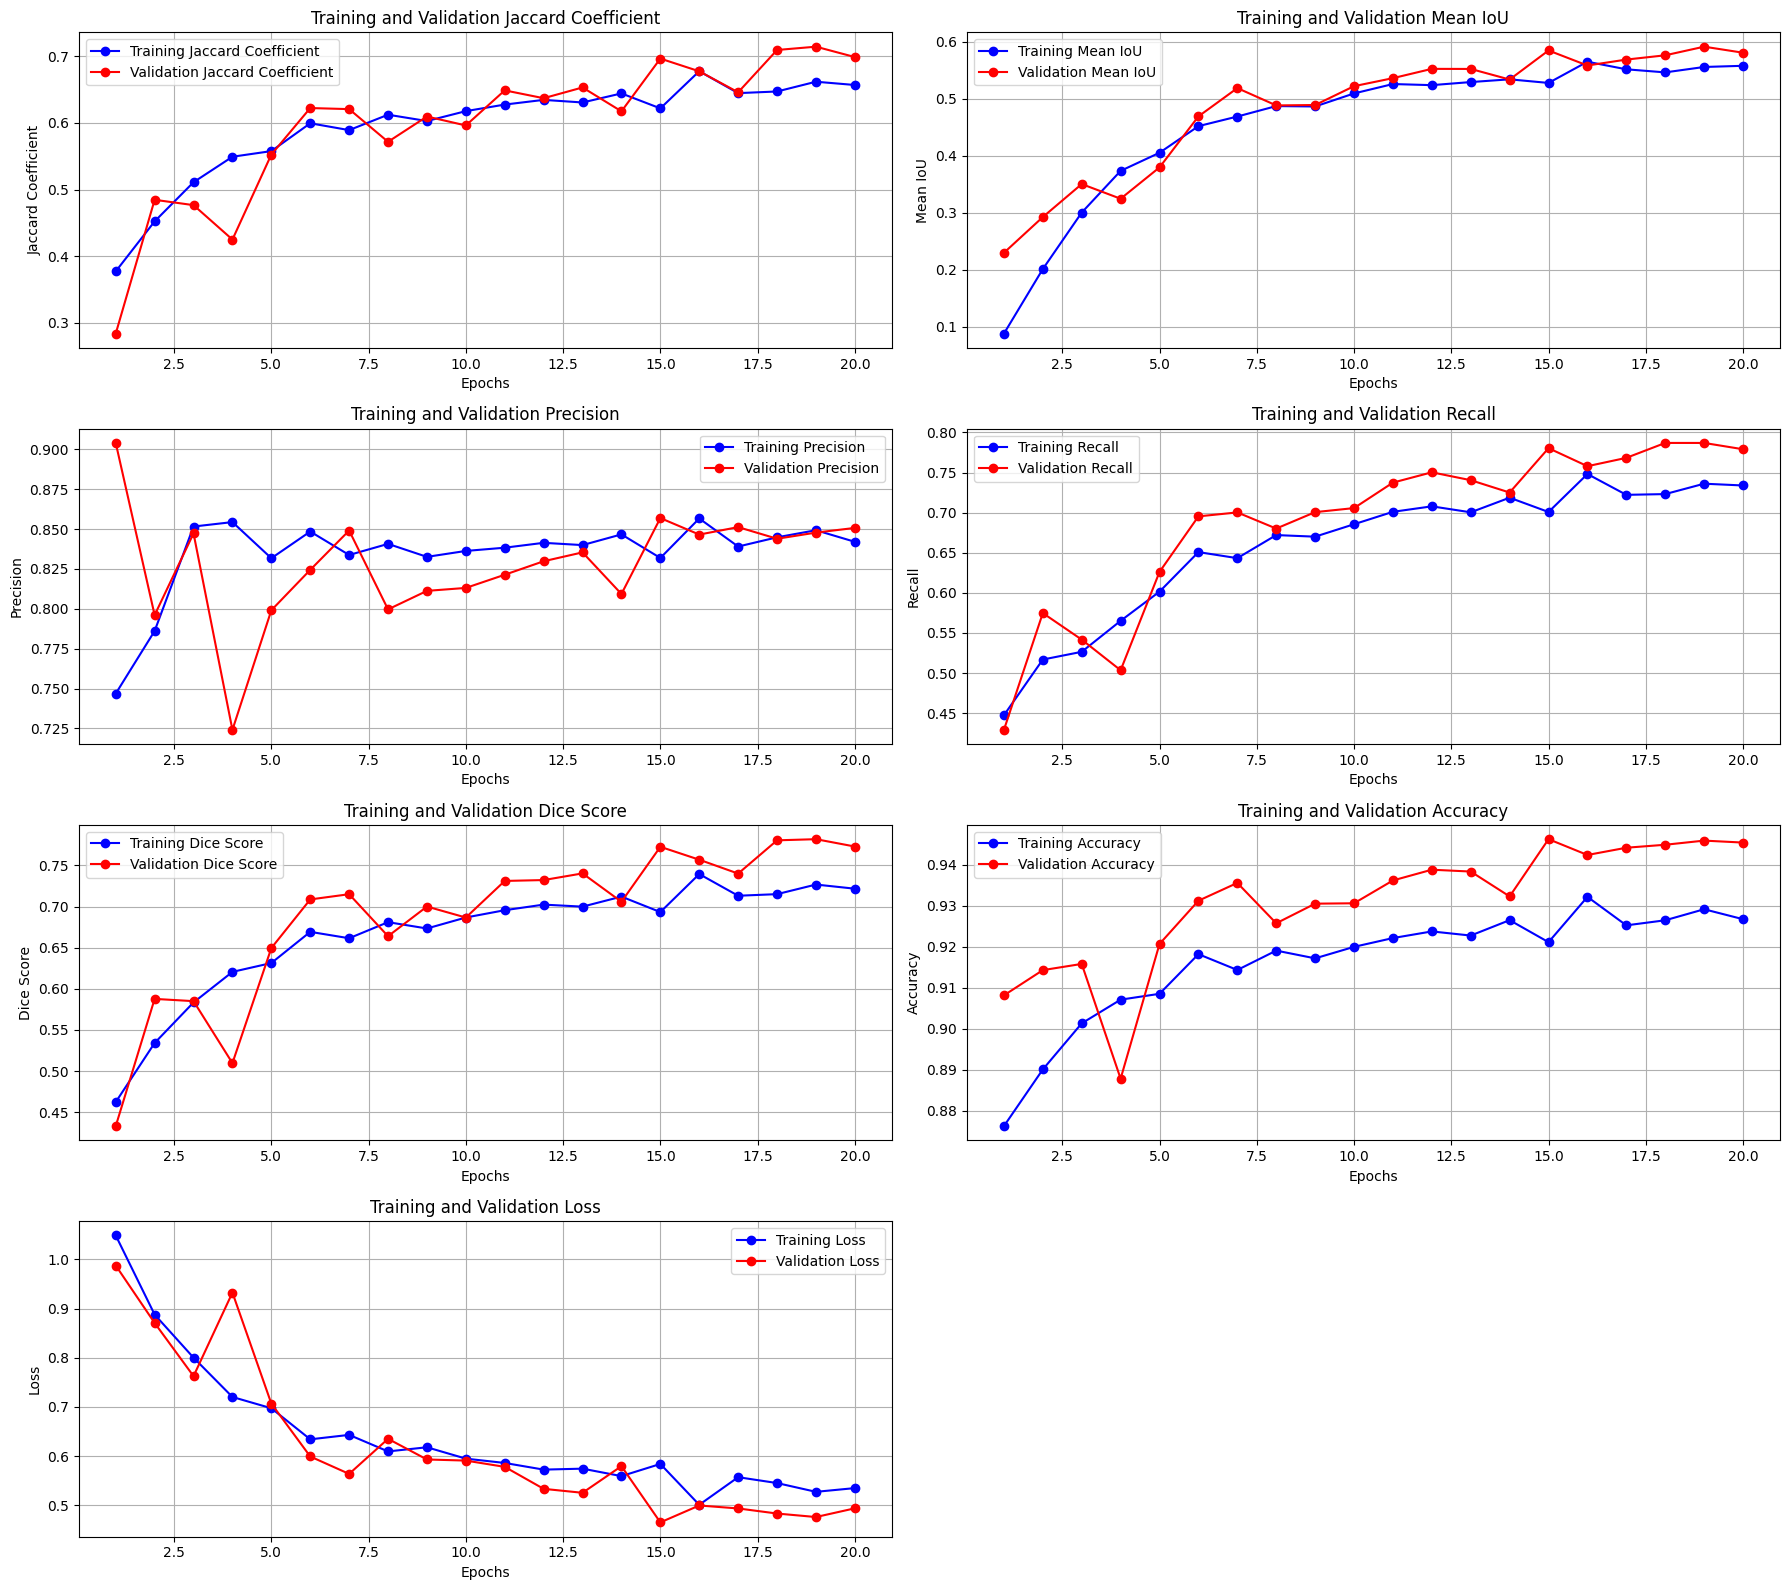

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 16))
    
    # Jaccard Coefficient
    plt.subplot(4, 2, 1)
    plt.plot(epochs, history.history['jaccard_coeff'], 'b', label='Training Jaccard Coefficient', marker= 'o')
    plt.plot(epochs, history.history['val_jaccard_coeff'], 'r', label='Validation Jaccard Coefficient', marker= 'o')
    plt.title('Training and Validation Jaccard Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Coefficient')
    plt.legend()
    plt.grid()

    # Mean IoU
    plt.subplot(4, 2, 2)
    plt.plot(epochs, history.history['one_hot_io_u_1'], 'b', label='Training Mean IoU', marker= 'o')
    plt.plot(epochs, history.history['val_one_hot_io_u_1'], 'r', label='Validation Mean IoU', marker= 'o')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid()

    # Precision
    plt.subplot(4, 2, 3)
    plt.plot(epochs, history.history['precision_1'], 'b', label='Training Precision', marker= 'o')
    plt.plot(epochs, history.history['val_precision_1'], 'r', label='Validation Precision', marker= 'o')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()

    # Recall
    plt.subplot(4, 2, 4)
    plt.plot(epochs, history.history['recall_1'], 'b', label='Training Recall', marker= 'o')
    plt.plot(epochs, history.history['val_recall_1'], 'r', label='Validation Recall', marker= 'o')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()

    # Dice Score
    plt.subplot(4, 2, 5)
    plt.plot(epochs, history.history['dice_score'], 'b', label='Training Dice Score', marker= 'o')
    plt.plot(epochs, history.history['val_dice_score'], 'r', label='Validation Dice Score', marker= 'o')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(4, 2, 6)
    plt.plot(epochs, history.history['segmentation_accuracy'], 'b', label='Training Accuracy', marker= 'o')
    plt.plot(epochs, history.history['val_segmentation_accuracy'], 'r', label='Validation Accuracy', marker= 'o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(4, 2, 7)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss', marker= 'o')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss', marker= 'o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)


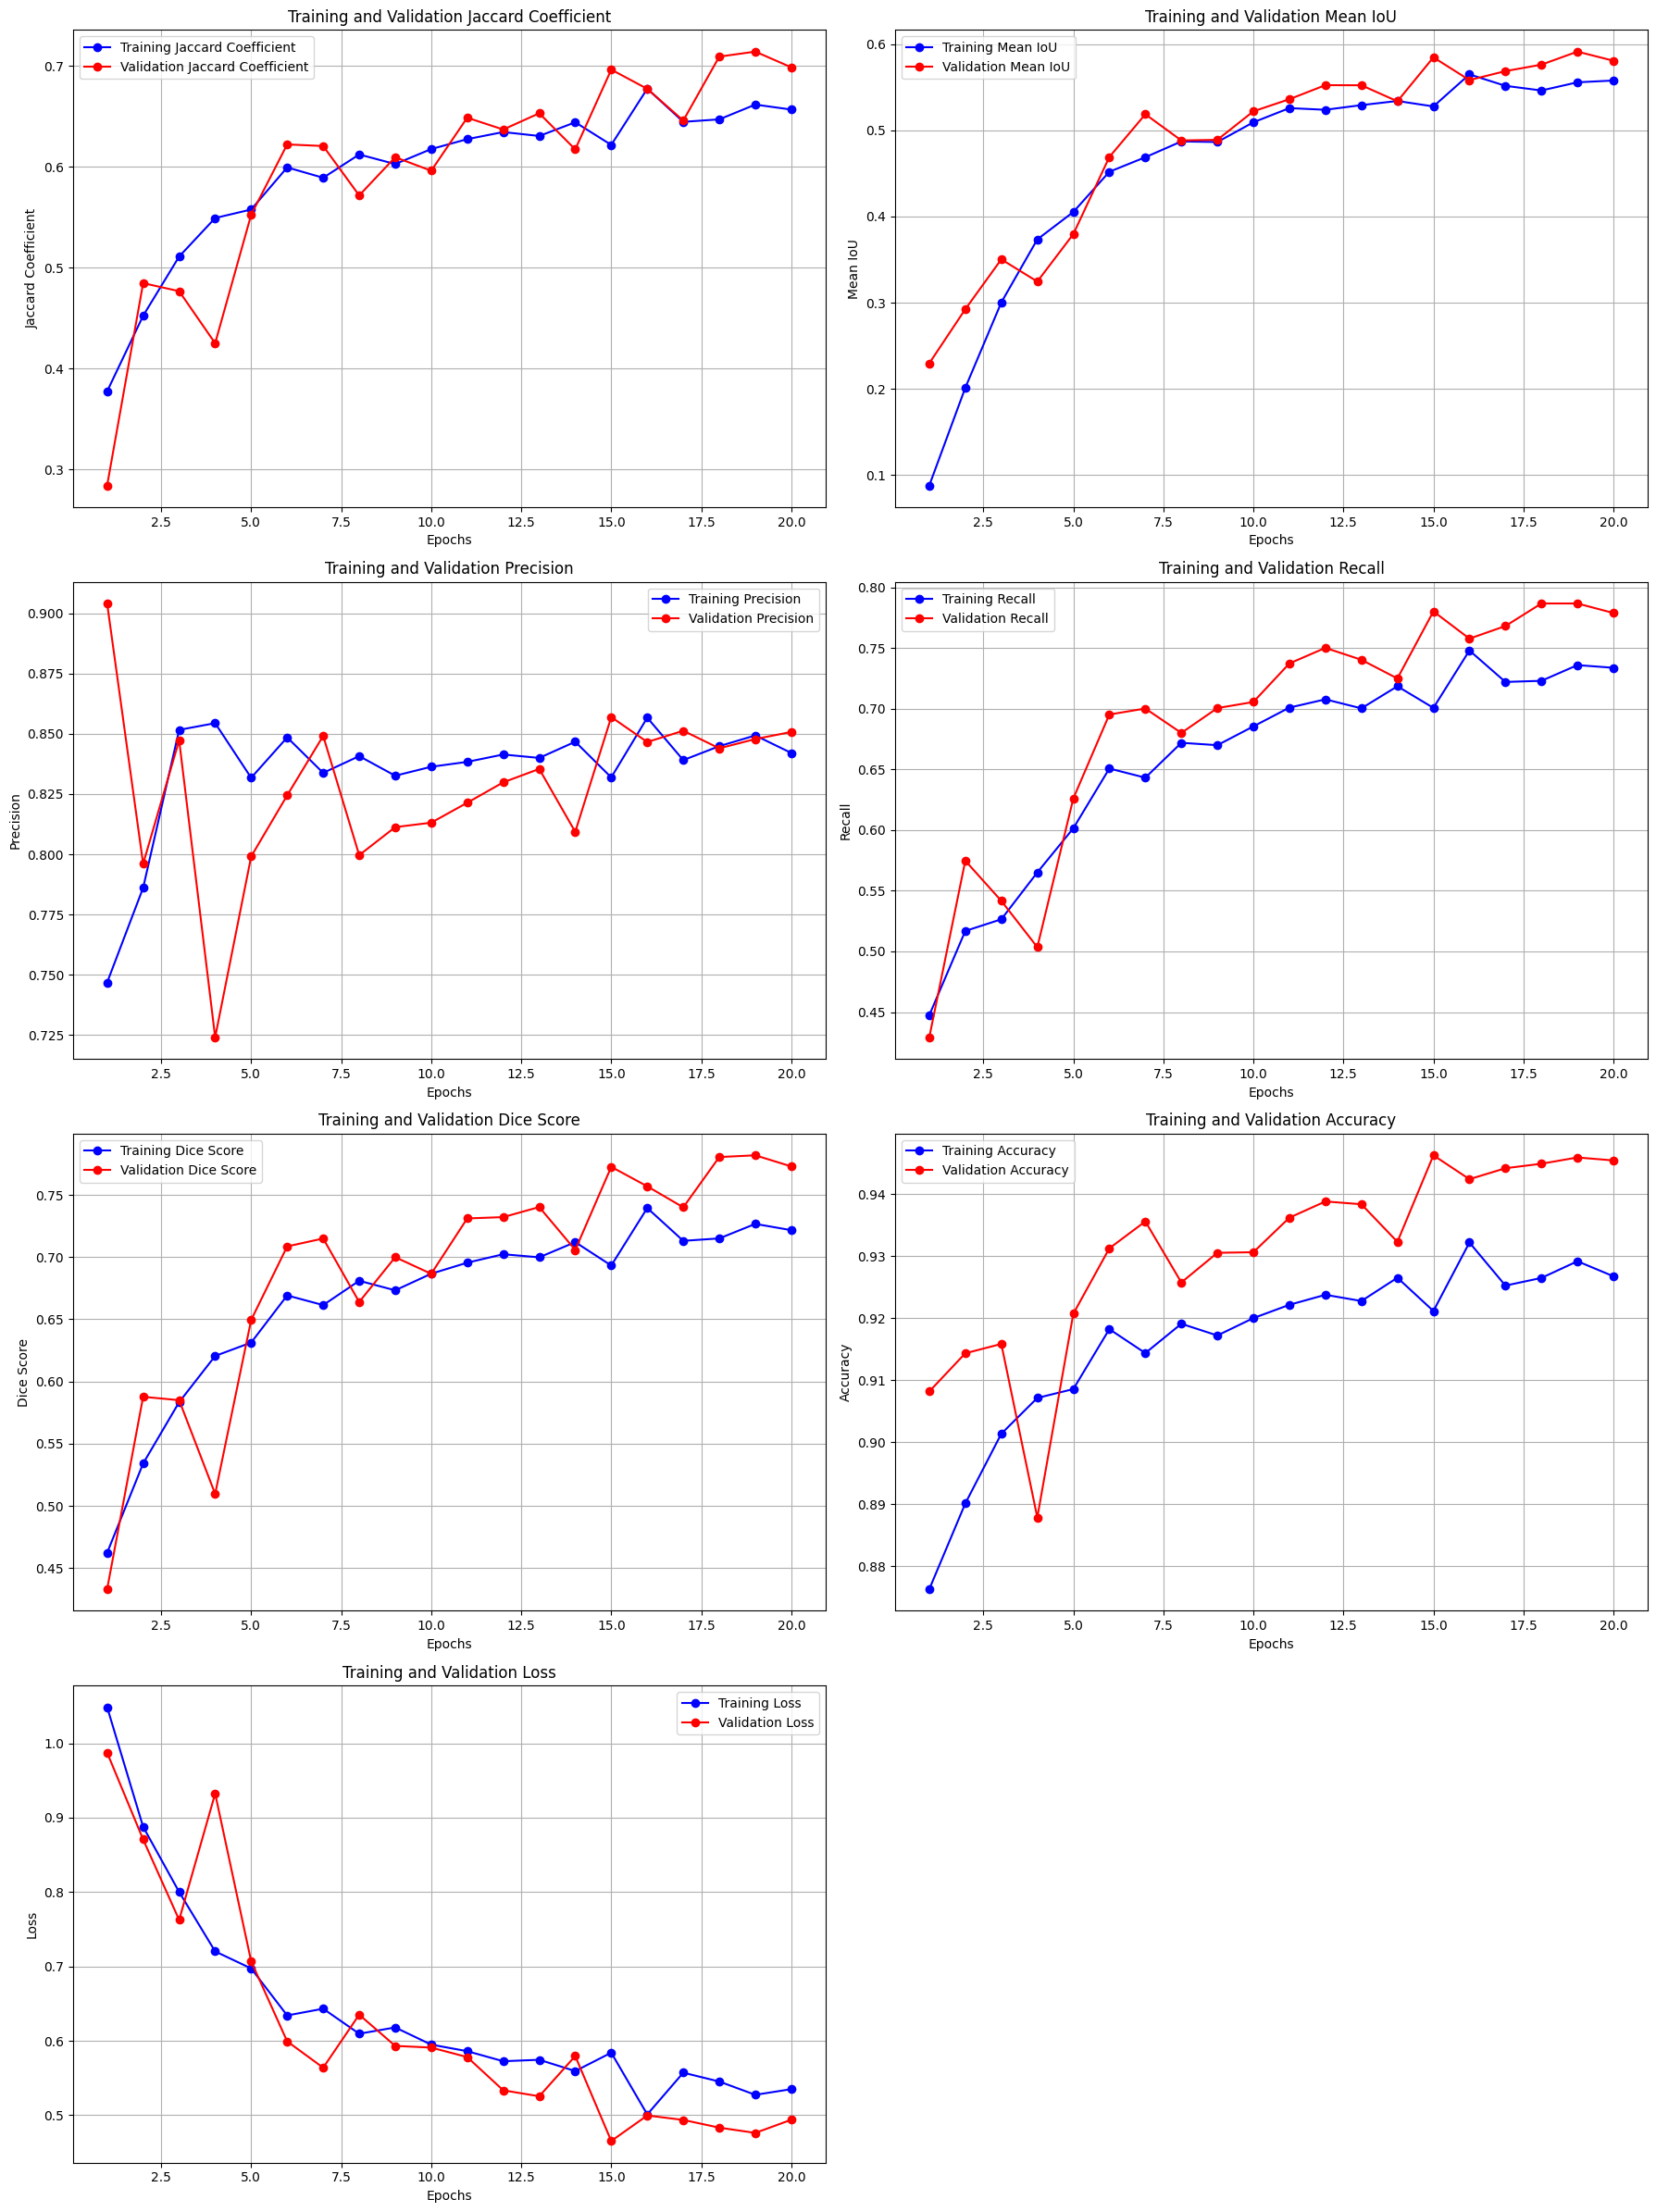

In [15]:
import matplotlib.pyplot as plt

# Function to plot the metrics in a 4x2 grid layout
def plot_training_history(history):
    # Extracting the history data
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    jaccard_coef = history.history['jaccard_coeff']
    val_jaccard_coef = history.history['val_jaccard_coeff']
    mean_iou = history.history['one_hot_io_u_1']  # Adjust as per actual key
    val_mean_iou = history.history['val_one_hot_io_u_1']  # Adjust as per actual key
    precision = history.history['precision_1']  # Adjust as per actual key
    val_precision = history.history['val_precision_1']  # Adjust as per actual key
    recall = history.history['recall_1']  # Adjust as per actual key
    val_recall = history.history['val_recall_1']  # Adjust as per actual key
    dice_score = history.history['dice_score']  # Adjust as per actual key
    val_dice_score = history.history['val_dice_score']  # Adjust as per actual key
    accuracy = history.history['segmentation_accuracy']  # Adjust as per actual key
    val_accuracy = history.history['val_segmentation_accuracy']  # Adjust as per actual key
    
    epochs = range(1, len(loss) + 1)
    
    # Plotting
    plt.figure(figsize=(18, 24))
    
    # Plotting Jaccard Coefficient
    plt.subplot(4, 2, 1)
    plt.plot(epochs, jaccard_coef, 'b', label='Training Jaccard Coefficient', marker= 'o')
    plt.plot(epochs, val_jaccard_coef, 'r', label='Validation Jaccard Coefficient', marker= 'o')
    plt.title('Training and Validation Jaccard Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Coefficient')
    plt.grid()
    plt.legend()
    
    # Plotting Mean IoU
    plt.subplot(4, 2, 2)
    plt.plot(epochs, mean_iou, 'b', label='Training Mean IoU', marker= 'o')
    plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU', marker= 'o')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.grid()
    plt.legend()
    
    # Plotting Precision
    plt.subplot(4, 2, 3)
    plt.plot(epochs, precision, 'b', label='Training Precision', marker= 'o')
    plt.plot(epochs, val_precision, 'r', label='Validation Precision', marker= 'o')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.grid()
    plt.legend()
    
    # Plotting Recall
    plt.subplot(4, 2, 4)
    plt.plot(epochs, recall, 'b', label='Training Recall', marker= 'o')
    plt.plot(epochs, val_recall, 'r', label='Validation Recall', marker= 'o')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.grid()
    plt.legend()
    
    # Plotting Dice Score
    plt.subplot(4, 2, 5)
    plt.plot(epochs, dice_score, 'b', label='Training Dice Score', marker= 'o')
    plt.plot(epochs, val_dice_score, 'r', label='Validation Dice Score', marker= 'o')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.grid()
    plt.legend()
    
    # Plotting Accuracy
    plt.subplot(4, 2, 6)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy', marker= 'o')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy', marker= 'o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    
    # Plotting Loss
    plt.subplot(4, 2, 7)
    plt.plot(epochs, loss, 'b', label='Training Loss', marker= 'o')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss', marker= 'o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)


In [16]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - dice_score: 0.6901 - jaccard_coeff: 0.6171 - loss: 0.6155 - one_hot_io_u_1: 0.5498 - precision_1: 0.8045 - recall_1: 0.7132 - segmentation_accuracy: 0.9237


[0.5873680710792542,
 0.5626856088638306,
 0.8142929673194885,
 0.7262549996376038,
 0.6297577023506165,
 0.7064515948295593,
 0.928019642829895]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


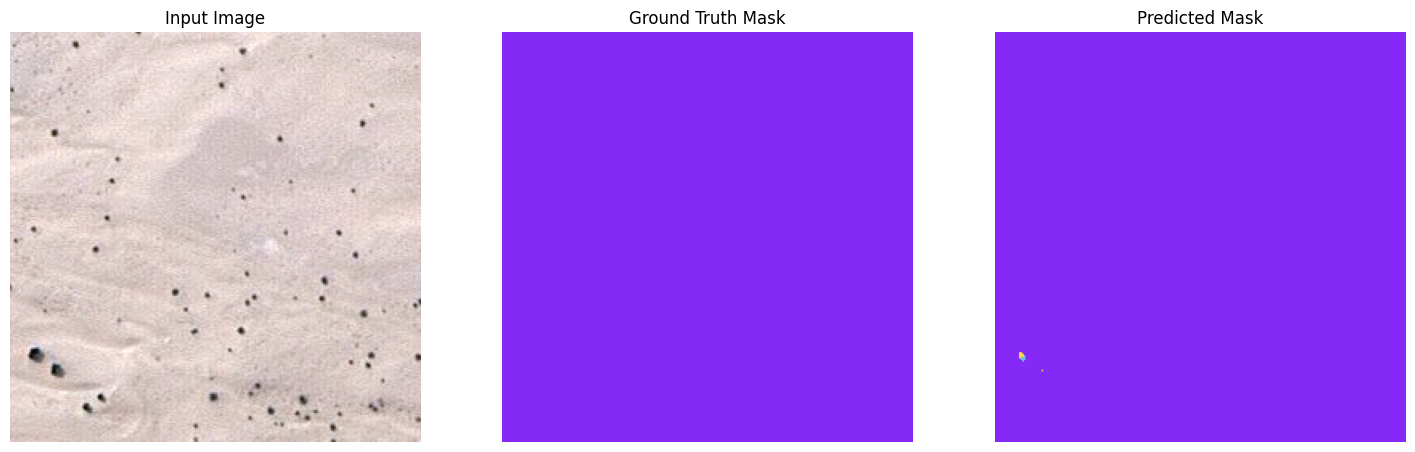

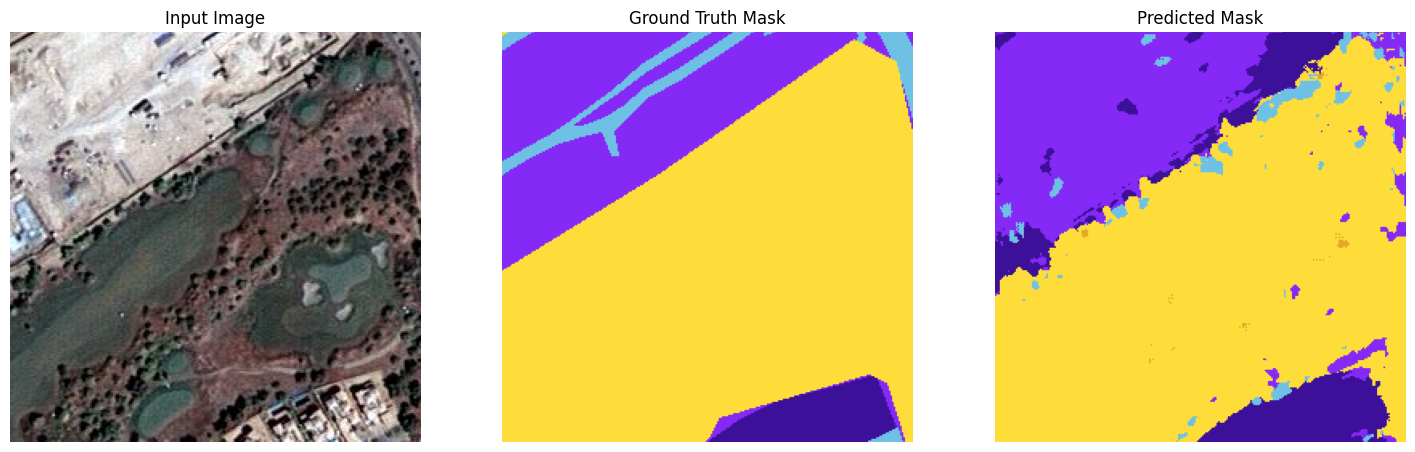

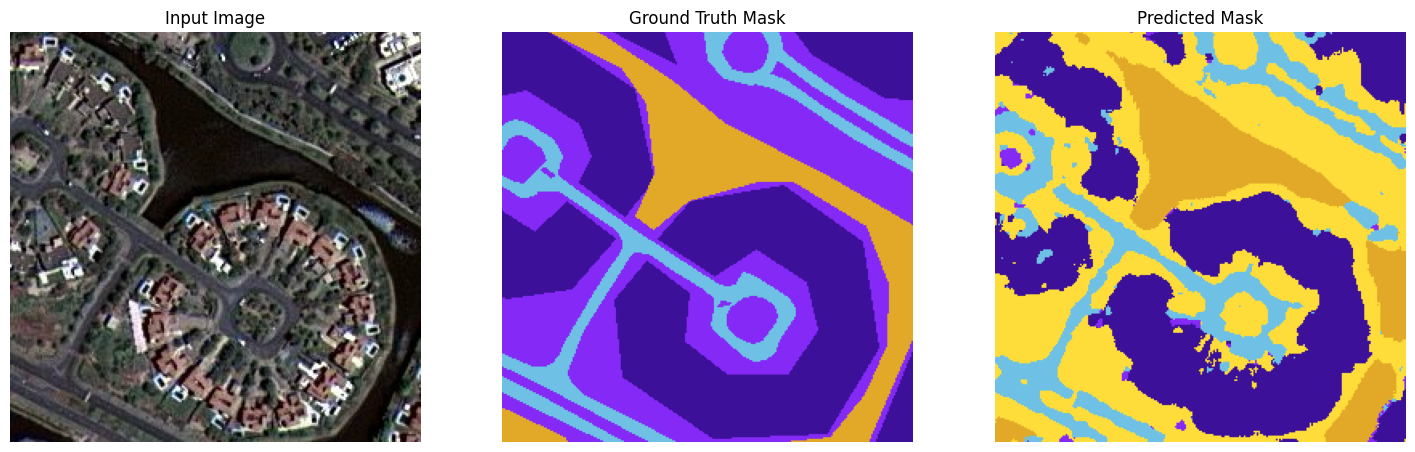

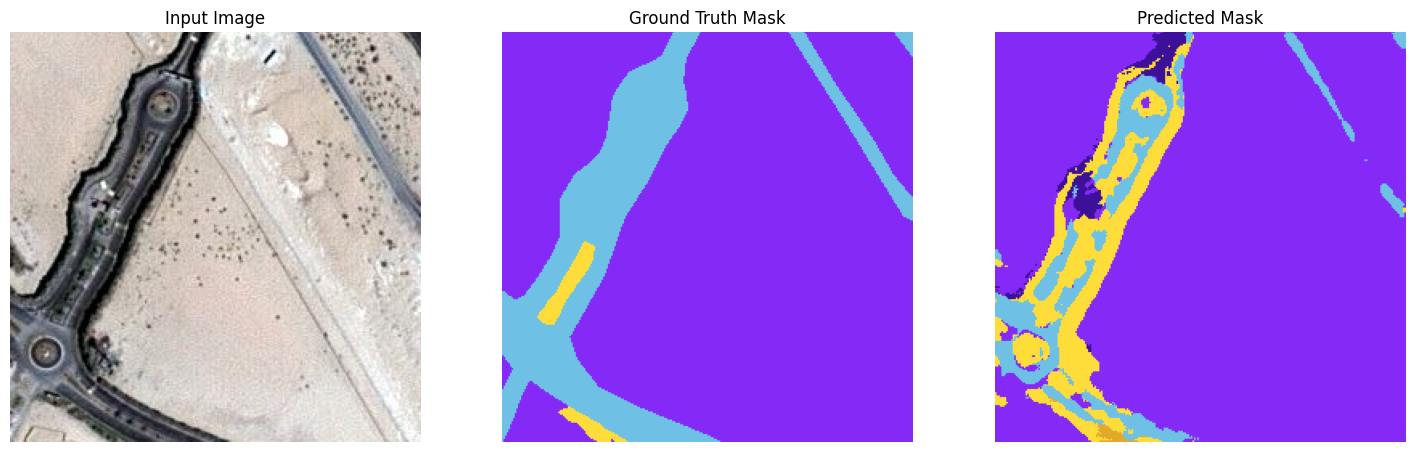

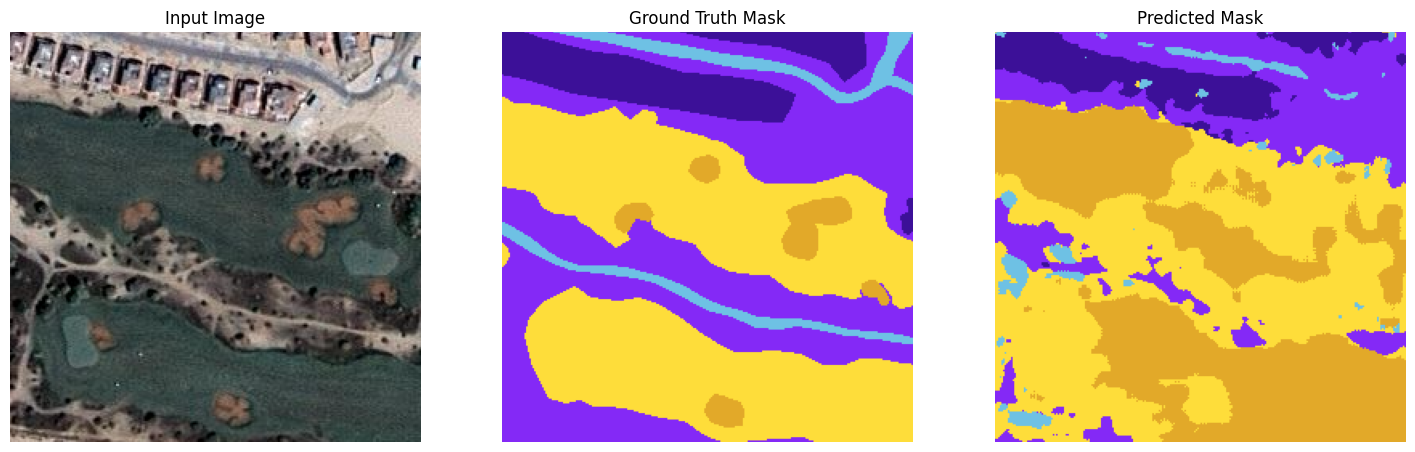

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Select a batch of test images to predict
num_samples = 5  # Number of samples to display
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
test_images = X_test[sample_indices]
test_masks = y_test[sample_indices]

# Generate predictions
predicted_masks = model.predict(test_images)

# Define a function to map class indices to RGB colors
def decode_mask(mask, color_dict):
    decoded_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_index, color in color_dict.items():
        decoded_mask[mask == class_index] = color
    return decoded_mask

# Map class index to RGB color (make sure this dictionary matches your classes)
class_colors_rgb = {
    0: (60, 16, 152),    # Building
    1: (132, 41, 246),   # Land
    2: (110, 193, 228),  # Road
    3: (254, 221, 58),   # Vegetation
    4: (226, 169, 41),   # Water
    5: (155, 155, 155)   # Unlabeled
}

# Display the results
for i in range(num_samples):
    fig, ax = plt.subplots(1, 3, figsize=(18, 8))
    
    # Display input image
    ax[0].imshow(test_images[i])
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    # Display ground truth mask
    true_mask = np.argmax(test_masks[i], axis=-1)  # Convert one-hot to label indices
    decoded_true_mask = decode_mask(true_mask, class_colors_rgb)
    ax[1].imshow(decoded_true_mask)
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    # Display predicted mask
    pred_mask = np.argmax(predicted_masks[i], axis=-1)  # Convert one-hot to label indices
    decoded_pred_mask = decode_mask(pred_mask, class_colors_rgb)
    ax[2].imshow(decoded_pred_mask)
    ax[2].set_title("Predicted Mask")
    ax[2].axis("off")

    plt.show()


# building a model using segmentation-models library

In [18]:
# !pip install segmentation-models==1.0.1
# !pip install efficientnet==1.0.0

# # run this cell to make sure keras is compatible with segmentation_models 
# with open('/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py', 'r') as file:
#     file_data = file.readlines()

# # Modify the line that causes the error
# for i, line in enumerate(file_data):
#     if 'keras.utils.generic_utils.get_custom_objects().update(custom_objects)' in line:
#         file_data[i] = line.replace('keras.utils.generic_utils', 'keras.utils')

# with open('/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py', 'w') as file:
#     file.writelines(file_data)


# # Check
# file_path = '/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py'
# with open(file_path, 'r') as file:
#     file_data = file.readlines()

# # Search for 'generic_utils'
# found = False
# for line in file_data:
#     if 'generic_utils' in line:
#         found = True
#         print(f"'generic_utils' found in line: {line.strip()}")

# if not found:
#     print("No instances of 'generic_utils' found in the file.")


# import segmentation_models as sm
# from segmentation_models import Unet


# from segmentation_models import get_preprocessing
# BACKBONE = 'resnet18'
# preprocess_input = get_preprocessing(BACKBONE)

# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)


# # Load pre-trained U-Net model 
# base_model = Unet(BACKBONE, encoder_weights='imagenet', activation = 'softmax', classes=num_classes)

# compile and then train the model as usual 